# Project on Vehicle counting


**Vehicle detection, tracking, counting, and speed estimation using YOLOv8
architecture with DeepSORT and ByteTrack**

in partial fulfillment for the Vision and Cognitive Services exam (MSc in CompSci @ Math.UniPd)


by Luca Veronese and Shakiba Farjood Fashalami

# Configuration

## Import libraries

Here we build and install the necessary packages (if they are not installed). 

In [1]:
!pip install numpy --quiet

In [2]:
!pip install opencv-python --quiet

In [3]:
!pip install matplotlib --quiet

In [4]:
!pip install scikit-learn --quiet

In [5]:
!pip install torch torchvision --quiet

In [6]:
!pip install tracker --quiet

We import the libraries in the namespace.

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

In [8]:
import collections
import numpy.typing as npt
import sys
from tqdm.notebook import tqdm

When running the notebook in Colab, we need the following cell because Google forbid the execution of `cv2.imshow` function for security reasons.

In [9]:
from google.colab.patches import cv2_imshow

In [10]:
def safe_cv2_imshow(image: cv2.VideoCapture, label: str = '', time: int = 1000, use_pyplot: bool = True) -> None:
    """
    Invoke `cv2_imshow`, `cv2.imshow` or `plt.imshow` 
    Args:
        image: an OpenCV VideoCapture object
        label: image's title
        time: when using Jupyter and opencv, ms the window will remain active
        use_pyplot: using matplotlib.pyplot
    """
    if use_pyplot is True:
        plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        plt.title(label)
        plt.axis('off')
        plt.show()
    elif 'google.colab' in str(get_ipython()):
        cv2_imshow(image)
    else:    
        cv2.destroyAllWindows()
        cv2.waitKey(time)
        cv2.imshow(label, image)


## Import video

In [11]:
from google.colab import drive

drive.mount('/content/gdrive')

In [12]:
SOURCE_FOLDER = f"."
# SOURCE_FOLDER = f"/content/gdrive/MyDrive/videos/"
SOURCE_FILE_NAME = f"test2.mp4"
SOURCE_VIDEO_PATH = f"{SOURCE_FOLDER}/{SOURCE_FILE_NAME}"
train_video = cv2.VideoCapture(SOURCE_VIDEO_PATH)

Let's check if the video import was successful and display the first frame if it is the case.

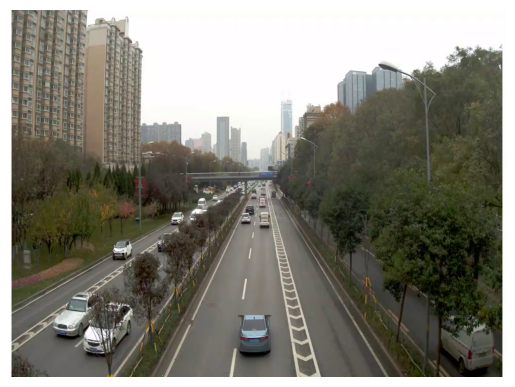

In [13]:
retval, frame = train_video.read()

if retval is False:
    print("Error reading the video file.")
else:
    safe_cv2_imshow(frame)

Now we print information about the video.

In [14]:
TOTAL_FRAMES = int(train_video.get(cv2.CAP_PROP_FRAME_COUNT))
IMG_HEIGHT, IMG_WIDTH, _ = frame.shape

print(f"Number of frames in the video: {TOTAL_FRAMES}")
print(f"Size of each frame: {IMG_HEIGHT} * {IMG_WIDTH}")

Number of frames in the video: 999
Size of each frame: 720 * 972


## Edge detection

We search for suitable values for low and high threshold of the Canny's edge detector.

We define a mask so that we can concentrate on the bottom half of image, so that we are sure to work "under the horizon".

In [15]:
mask = np.zeros((IMG_HEIGHT, IMG_WIDTH), dtype=np.uint8)
mask[int(IMG_HEIGHT / 2):, :] = 255


def detect_edges(blur: npt.ArrayLike, low_thresh: int, high_thresh: int, mask: npt.ArrayLike) -> np.array:
    can = cv2.Canny(blur, low_thresh, high_thresh)
    return cv2.bitwise_and(can, mask)

As we reduce both low and high thresholds, the number of detected edges increases.

In [16]:
low_threshold = 110
high_threshold = 210

if retval is False:
    print("Video file not yet configured: cells above not runned or run with error.")
else:
    blur = cv2.GaussianBlur(frame, (13, 13), 1)
    canny_edges = np.zeros_like(blur, dtype=np.uint8)
    while np.count_nonzero(canny_edges) < 28000:
        low_threshold -= 5
        high_threshold -= 10
        canny_edges = detect_edges(blur, low_threshold, high_threshold, mask)

        print("low thresh: {}, high thresh: {}, num. of edges {}".format(low_threshold, high_threshold,
                                                                         np.count_nonzero(canny_edges)))


low thresh: 105, high thresh: 200, num. of edges 13810
low thresh: 100, high thresh: 190, num. of edges 14474
low thresh: 95, high thresh: 180, num. of edges 15250
low thresh: 90, high thresh: 170, num. of edges 16475
low thresh: 85, high thresh: 160, num. of edges 18076
low thresh: 80, high thresh: 150, num. of edges 19530
low thresh: 75, high thresh: 140, num. of edges 21660
low thresh: 70, high thresh: 130, num. of edges 24295
low thresh: 65, high thresh: 120, num. of edges 27018
low thresh: 60, high thresh: 110, num. of edges 30063


Canny's edge detector low threshold set to 60, high threshold set to 110


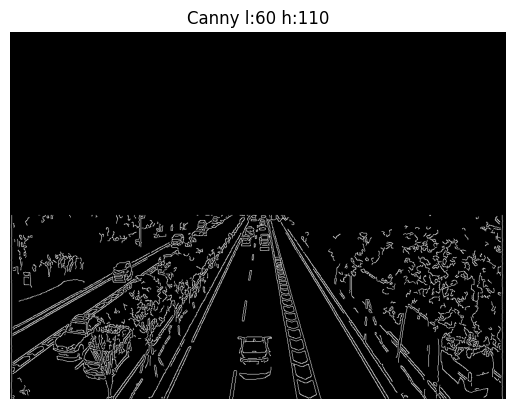

In [17]:
print(f"Canny's edge detector low threshold set to {low_threshold}, high threshold set to {high_threshold}")

safe_cv2_imshow(canny_edges, f"Canny l:{low_threshold} h:{high_threshold}")  

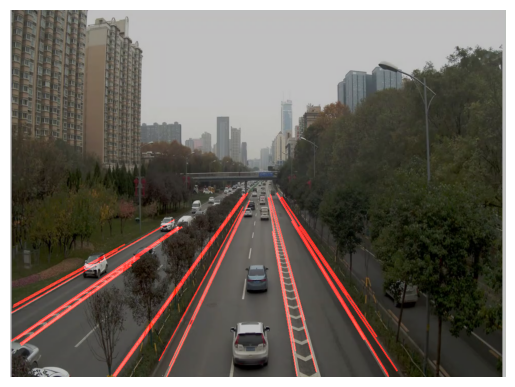

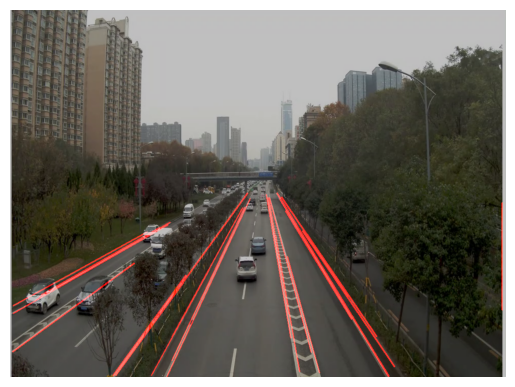

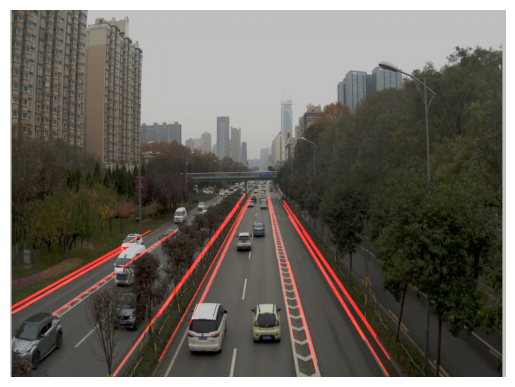

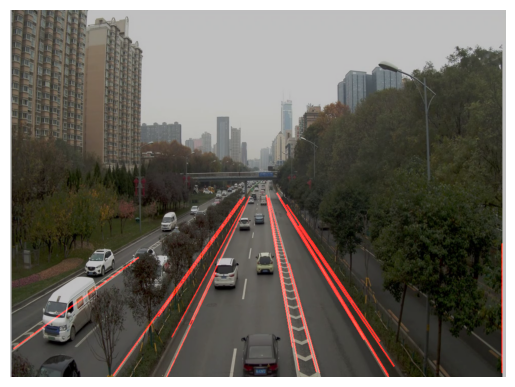

In [18]:
train_video.set(cv2.CAP_PROP_POS_FRAMES, 0)
hough_lines = []

for i in range(0, 100):
    retval, frame = train_video.read()

    # Check if the frame was successfully read
    if retval is True:

        blur = cv2.GaussianBlur(frame, (13, 13), 1)
        masked_edges = detect_edges(blur, low_threshold, high_threshold, mask)

        detected_lines = cv2.HoughLinesP(masked_edges, rho=1, theta=np.pi / 200, threshold=100,
                                         minLineLength=IMG_HEIGHT / 4,
                                         maxLineGap=10)

        line_image = np.zeros_like(frame)
        for line in detected_lines:
            x1, y1, x2, y2 = line[0]
            steepness = abs((y2 - y1) / (x2 - x1)) if x1 != x2 else sys.float_info.max
            if steepness > 0.1:
                hough_lines.append(line)
                cv2.line(line_image, (x1, y1), (x2, y2), (0, 0, 255), 2)

        if i % 25 == 24:
            safe_cv2_imshow(cv2.addWeighted(frame, 0.75, line_image, 0.90, 0))

We overlay all the Hough's lines that were detected onto a frame.

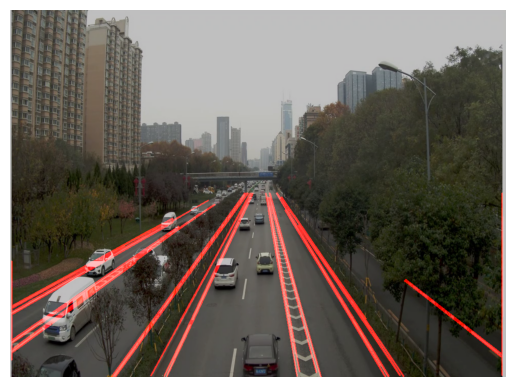

In [20]:
line_image = np.zeros_like(frame)
for line in hough_lines:
    x1, y1, x2, y2 = line[0]
    steepness = abs((y2 - y1) / (x2 - x1)) if x1 != x2 else sys.float_info.max
    if steepness > 0.1:
        cv2.line(line_image, (x1, y1), (x2, y2), (0, 0, 255), 2)

blended_image = cv2.addWeighted(frame, 0.75, line_image, 0.90, 0)
safe_cv2_imshow(blended_image, "", 4000)

## Clustering edges to find regions on the road

In [21]:
horizon_top = 430
horizon_bottom = 680

print(f"y = {horizon_top} and y = {horizon_bottom} are considered distant 50 meters")

y = 430 and y = 680 are considered distant 50 meters


Before clustering, we ensure that all edges have the same length.

In [22]:
def find_intersection_points(line1, line2):
    x1, y1, x2, y2 = line1
    x3, y3, x4, y4 = line2
    A = np.array([
        [y2 - y1, x1 - x2],
        [y4 - y3, x3 - x4]
    ])
    b = np.array([
        [y2 * x1 - x2 * y1],
        [y4 * x3 - x4 * y3]
    ])
    try:
        intersection_point = np.linalg.solve(A, b)
        return int(intersection_point[0][0]), int(intersection_point[1][0])
    except np.linalg.LinAlgError:
        # Handle the case where lines are parallel
        return None


def find_intersections(lines, bottom_y, top_y):
    result = np.empty((len(lines), 4), dtype=int)
    
    for i, line in enumerate(lines):
        x1, y1 = find_intersection_points(line[0], (0, top_y, 100, top_y))
        x2, y2 = find_intersection_points(line[0], (0, bottom_y, 100, bottom_y))
        result[i] = np.array([x1, y1, x2, y2], dtype=int)

    return result

In [23]:
road_lines = find_intersections(hough_lines, bottom_y=horizon_bottom, top_y=horizon_top)

In [24]:
for line in road_lines:
    _, y1, _, y2 = line
    assert (y1 == horizon_top) and (y2 == horizon_bottom)

To determine number of clusters, we perform clustering with K-Means for each $k$ within the range 3 and 12. We then select the $k$ that yields the highest silhouette value

In [25]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

k_values = range(3, 12)

# compute silhouette coefficient foreach k value
silhouette_scores = np.empty(len(k_values), float)
for i, k in enumerate(k_values):
    kmeans = KMeans(n_clusters=k, n_init=10)
    cluster_indexes = kmeans.fit_predict(road_lines)
    silhouette_scores[i] = silhouette_score(road_lines, cluster_indexes)

Let's plot the results:

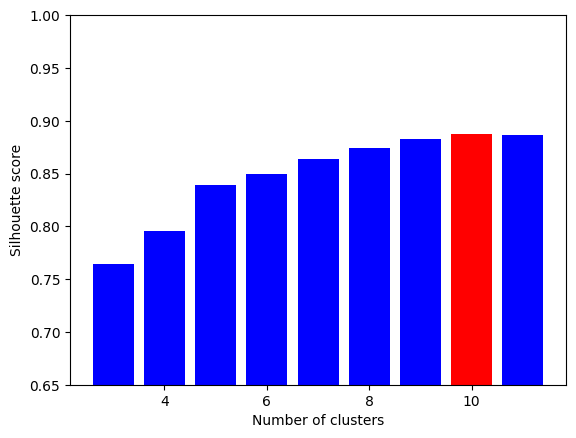

Optimal number of clusters:  10


In [26]:
colors = ['blue'] * len(k_values)  # default color for all bars: blue
colors[np.argmax(silhouette_scores)] = 'red'  # color the tallest bar: red

# plot silhouette coefficients against the number of clusters
plt.bar(k_values, silhouette_scores, align='center', color=colors)
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette score')
plt.ylim(0.65, 1.0)
plt.show()

k = k_values[np.argmax(silhouette_scores)]
print('Optimal number of clusters: ', k)

In [27]:
# initialize the KMeans object
kmeans = KMeans(n_clusters=k, init='k-means++', n_init=10)
kmeans.fit(road_lines)

# get the clusters' centroids
centroids = np.round(kmeans.cluster_centers_).astype(np.int32)

# sort centroid by intersection w/ top horizon 
centroids_sorted = sorted(centroids, key=lambda x: x[0])

The clustering operation gave us a set of lines. We proceed to superimpose these lines onto a frame and draw quadrilateral regions based on these lines. Finally, we will choose a four-sided region within which we will detect vehicles.

In [28]:
def get_regions_coords(lines) -> list:
    """
    Takes in a list of lines and returns a list of regions.
    
    Parameters:
            lines (list): A list of lines, where each line is represented as a tuple of four coordinates (x1, y1, x2, y2) that represent the starting and ending points of the line. 
    
    Returns: A list of regions, where each region is represented as a numpy array with shape (4, 2). Each row of the numpy array contains the x and y coordinates of a point in the region.
"""
    result = []
    for i in range(0, len(lines) - 1):
        x1, y1, x2, y2 = lines[i]
        x3, y3, x4, y4 = lines[i + 1]
        region = np.array([[x1, y1], [x2, y2], [x4, y4], [x3, y3]])
        result.append(region)
    return result

polygons = get_regions_coords(centroids_sorted)

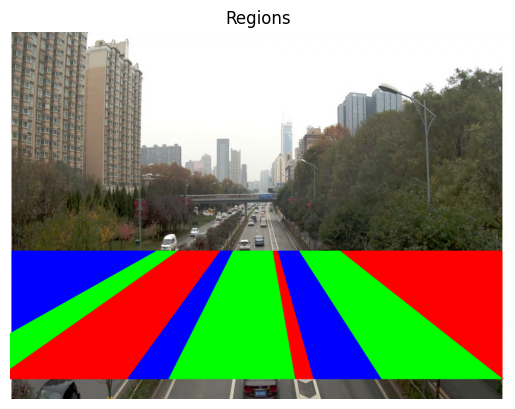

In [29]:
img_regions = frame

# Draw the polygons on the image
for i, poly in enumerate(polygons):
    cv2.fillPoly(img_regions, [poly], color=(255 * (i % 3 == 0), 255 * (i % 3 == 1), 255 * (i % 3 == 2)),
                 lineType=cv2.LINE_AA)

# Add transparency to the image
overlay = img_regions.copy()
opacity = 0.6
img_regions = cv2.addWeighted(overlay, opacity, frame, 1 - opacity, 0)
safe_cv2_imshow(img_regions, "Regions", 5000)

In [30]:
def get_inclusive_rects(rects: list, a: int, b: int) -> np.ndarray:
    """
    Given a list `rects` of rectangles and two numbers `a` and `b`, it returns the rectangle that includes all the rectangles between position `a` (included) and `b` (excluded)
    
    Args:
        rects: list of rectangles, each one of shape [4,2]
        a: index of the first rectangle to consider
        b: index of the last rectangle to consider
    """
    p0 = rects[a][0]
    p1 = rects[a][1]
    p2 = rects[b - 1][2]
    p3 = rects[b - 1][3]
    return np.asarray([p0, p1, p2, p3])

In [31]:
polygon_source = get_inclusive_rects(polygons, 4, 7)

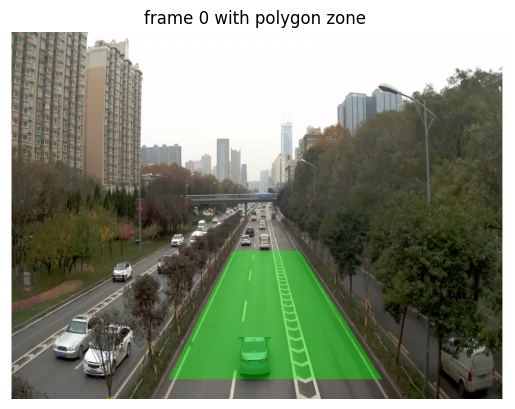

In [32]:
train_video.set(cv2.CAP_PROP_POS_FRAMES, 0)

retval, frame_c = train_video.read()
overlay = frame_c.copy()

cv2.fillPoly(frame_c, [polygon_source], color=(0, 255, 0), lineType=cv2.LINE_AA)
# Add transparency to the image
opacity = 0.6
img_reg = cv2.addWeighted(overlay, opacity, frame_c, 1 - opacity, 0, frame_c)
safe_cv2_imshow(img_reg, "frame 0 with polygon zone ", 1800)

In [33]:
SOURCE = sorted(np.array(polygon_source), key=lambda x: x[1])

SOURCE[0], SOURCE[1] = (SOURCE[0], SOURCE[1]) if SOURCE[0][0] < SOURCE[1][0] else (SOURCE[1], SOURCE[0])
SOURCE[2], SOURCE[3] = (SOURCE[2], SOURCE[3]) if SOURCE[2][0] > SOURCE[3][0] else (SOURCE[3], SOURCE[2])

SOURCE = np.array(SOURCE)
print(SOURCE)

[[437 430]
 [567 430]
 [728 680]
 [311 680]]


In [34]:
# enlarge the polygon zone
detection_zone = polygon_source.copy()
detection_zone[0][0] = max(polygon_source[0][0] - 100, 0)
detection_zone[1][0] = max(polygon_source[1][0] - 100, 0)
detection_zone[2][0] = min(polygon_source[2][0] + 100, IMG_WIDTH - 1)
detection_zone[3][0] = min(polygon_source[3][0] + 100, IMG_WIDTH - 1)

# YOLO Vehicle detection and counting

In [35]:
!pip install supervision==0.18.0 --quiet
!pip install ultralytics==8.1.8 --quiet

In [39]:
!gdown "https://drive.google.com/uc?id=11ZSZcG-bcbueXZC3rN08CM0qqX3eiHxf&confirm=t"
#if gdown doesn't work, open the link in browser
!unzip 'deep_sort_pytorch.zip'

## DeepSORT

In [37]:
from statistics import mean
from typing import List

import supervision as sv

import torch
from supervision import LineZone, Point, draw_text
from ultralytics.models.yolo.detect import DetectionPredictor
from ultralytics.utils.ops import xyxy2xywh
from ultralytics.utils.plotting import Annotator, colors
from supervision.detection.core import Detections

from SpeedEstimator import SpeedEstimator
from ViewTransformer import ViewTransformer
from deep_sort_pytorch.deep_sort import DeepSort
from deep_sort_pytorch.utils.parser import get_config


In [38]:
dz = sorted(np.array(detection_zone), key=lambda x: x[1])

dz[0], dz[1] = (dz[0], dz[1]) if dz[0][0] < dz[1][0] else (dz[1], dz[0])
dz[2], dz[3] = (dz[2], dz[3]) if dz[2][0] > dz[3][0] else (dz[3], dz[2])

dz = np.array(SOURCE)

In [43]:
from copy import deepcopy
from collections import defaultdict

deepsort = None

CONFIDENCE_THRESHOLD = 0.4
IOU_THRESHOLD = 0.5
CLASS_ID = [2, 3, 5, 7]

video_info = sv.VideoInfo.from_video_path(video_path=SOURCE_VIDEO_PATH)
polygon = SOURCE.reshape((-1, 1, 2))
polygon_zone = sv.PolygonZone(
    polygon=SOURCE,
    frame_resolution_wh=video_info.resolution_wh
)

points = {
    "x1": -100. + (SOURCE[0][0] + SOURCE[3][0]) / 2.,
    "y1": (SOURCE[0][1] + SOURCE[3][1]) / 2.,
    "x2": 100. + (SOURCE[1][0] + SOURCE[2][0]) / 2.,
    "y2": (SOURCE[1][1] + SOURCE[2][1]) / 2.
}

start_point = Point(x=points["x1"], y=points["y1"])
end_point = Point(x=points["x2"], y=points["y2"])

line_counter_dict = {
    "cars": LineZone(start_point, end_point),
    "motorcycles": LineZone(start_point, end_point),
    "buses": LineZone(start_point, end_point),
    "trucks": LineZone(start_point, end_point)
}
SOURCE = np.array([
    [420, 430],
    [580, 430],
    [758, 680],
    [278, 680]
])

TARGET_WIDTH = 12
TARGET_HEIGHT = 50

TARGET = np.array([
    [0, 0],
    [TARGET_WIDTH - 1, 0],
    [TARGET_WIDTH - 1, TARGET_HEIGHT - 1],
    [0, TARGET_HEIGHT - 1],
])


def init_tracker():
    global deepsort
    cfg_deep = get_config()
    cfg_deep.merge_from_file("deep_sort_pytorch/configs/deep_sort.yaml")

    deepsort = DeepSort(cfg_deep.DEEPSORT.REID_CKPT,
                        max_dist=cfg_deep.DEEPSORT.MAX_DIST, min_confidence=cfg_deep.DEEPSORT.MIN_CONFIDENCE,
                        nms_max_overlap=cfg_deep.DEEPSORT.NMS_MAX_OVERLAP,
                        max_iou_distance=cfg_deep.DEEPSORT.MAX_IOU_DISTANCE,
                        max_age=cfg_deep.DEEPSORT.MAX_AGE, n_init=cfg_deep.DEEPSORT.N_INIT,
                        nn_budget=cfg_deep.DEEPSORT.NN_BUDGET,
                        use_cuda=True)


class DeepsortPredictor(DetectionPredictor):
    speed_estimator = SpeedEstimator(trk_history=defaultdict(list), view_transformer=ViewTransformer(SOURCE, TARGET))

    def write_results(self, idx, results, batch):
        p, im, im0 = batch
        log_string = ""
        if len(im.shape) == 3:
            im = im[None]  # expand for batch dim

        self.data_path = p
        self.txt_path = ""
        log_string += "%gx%g " % im.shape[2:]  # print string
        result = results[idx]
        log_string += result.verbose()

        im0 = im0.copy()

        detections = sv.Detections.from_ultralytics(result)
        detections = detections[polygon_zone.trigger(detections)]
        detections = detections[np.isin(detections.class_id, CLASS_ID)]
        detections = detections[detections.confidence > CONFIDENCE_THRESHOLD]
        detections = detections.with_nms(IOU_THRESHOLD)

        xywhs = torch.from_numpy(xyxy2xywh(detections.xyxy))
        confss = torch.from_numpy(detections.confidence)
        oids = detections.class_id.tolist()
        
        outputs = deepsort.update(xywhs, confss, oids, im0)  # [[x1, y1, x2, y2, track_id, track_oid],...]

        bbox_xyxy: List[List[float]] = []
        object_id: List[int] = []
        identities: List[int] = []
        
        if len(outputs) > 0:
            bbox_xyxy, identities, object_id = outputs[:, :4], outputs[:, -2], outputs[:, -1]
            tracked_detections = Detections(xyxy=bbox_xyxy, class_id=object_id, tracker_id=identities)

            # Update vehicle counting
            for i, (_, el) in enumerate(line_counter_dict.items()):
                el.trigger(tracked_detections[np.isin(tracked_detections.class_id, CLASS_ID[i])])

            # Update track_history w/ values for the current frame
            for i, track_id in enumerate(identities):
                track = self.speed_estimator.trk_history[track_id]

                bbox_bottomcenter = (mean(bbox_xyxy[i, 0:4:2]), bbox_xyxy[i][3])
                track.append(bbox_bottomcenter)
                if len(track) > 15:
                    track.pop(0)


        plot_args = {
            "names": self.model.names,
            "pred_boxes": bbox_xyxy,
            "cls_list": object_id,
            "ids": identities,
            "show_boxes": self.args.show_boxes,
            "img": im0,
            "speed_estimator": self.speed_estimator
        }

        self.plotted_img = plot(**plot_args)
        return log_string

In [44]:
def plot(names, pred_boxes, cls_list, ids, img=None, show_boxes=True, speed_estimator=None) -> np.ndarray:
    """
    Plots the detection results on an input RGB image. Accepts a numpy array (cv2).

    Args:
        names (List[str]): COCO's classes names
        pred_boxes (List[List[float]]): Detected boxes in the format xyxy
        ids (List[int]): Track IDs for pred_boxes
        cls_list (List[int]): List of integer representing COCO's classes for `pred_boxes`
        img (numpy.ndarray): Plot to another image. if not, plot to original image.
        show_boxes (bool): Whether to plot the bounding boxes.
        speed_estimator: `SpeedEstimator` object

    Returns:
        (numpy.ndarray): A numpy array of the annotated image.
    """
    scene = deepcopy(img)
    scene = draw_text(scene=scene, text=f"Up-wards", text_anchor=Point(x=600, y=30))
    scene = draw_text(scene=scene, text=f"Down-wards", text_anchor=Point(x=750, y=30))

    for i, (key, value) in enumerate(line_counter_dict.items()):
        scene = draw_text(scene=scene, text=f"{key}: {value.out_count}", text_anchor=Point(x=600, y=50 + 20 * i))
        scene = draw_text(scene=scene, text=f"{key}: {value.in_count}", text_anchor=Point(x=750, y=50 + 20 * i))

    annotator = Annotator(scene, font="Arial.ttf")
    annotator.sf = 0.5
    annotator.tf = 1
    annotator.draw_region(polygon)

    i = len(pred_boxes) - 1

    if pred_boxes is not None and show_boxes:
        for d in reversed(pred_boxes):
            c = int(cls_list[i])
            id = int(ids[i])

            label = ("" if id is None else f"id:{id} ") + names[c]
            box = d.squeeze()
            if speed_estimator is not None:
                annotator.draw_centroid_and_tracks(speed_estimator.trk_history[id])
                if len(speed_estimator.trk_history[id]) >= 15:
                    speed, error = speed_estimator.estimate_speed(id)
                    label += f" {int(speed)}+-{error:.1f} kmh"  # ±

            annotator.box_label(box, label, color=colors(c, True), rotated=False)
            i -= 1

    annotator.draw_region(  # detection lines
        reg_pts=[[int(points["x1"]), int(points["y1"])], [int(points["x2"]), int(points["y2"])]],
        color=(255, 255, 0),
        thickness=1
    )

    return annotator.result()


In [45]:
def predict(model, source) -> None:
    init_tracker()
    video_info = sv.VideoInfo.from_video_path(video_path=source)
    global polygon_zone
    polygon_zone = sv.PolygonZone(
        polygon=SOURCE,
        frame_resolution_wh=video_info.resolution_wh
    )
    args = dict(model=model, source=source)
    predictor = DeepsortPredictor(overrides=args)
    predictor()


predict(model='yolov8s.pt', source="./test2.mp4")

Ultralytics YOLOv8.1.8 🚀 Python-3.8.18 torch-1.13.1+cu117 CPU (AMD Ryzen 5 3600 6-Core Processor)
YOLOv8s summary (fused): 168 layers, 11156544 parameters, 0 gradients, 28.6 GFLOPs

WARNING ⚠️ inference results will accumulate in RAM unless `stream=True` is passed, causing potential out-of-memory
errors for large sources or long-running streams and videos. See https://docs.ultralytics.com/modes/predict/ for help.

Example:
    results = model(source=..., stream=True)  # generator of Results objects
    for r in results:
        boxes = r.boxes  # Boxes object for bbox outputs
        masks = r.masks  # Masks object for segment masks outputs
        probs = r.probs  # Class probabilities for classification outputs
video 1/1 (1/999) /home/lucav/Documents/Master/vcs/project/test2.mp4: 480x640 10 cars, 3 trucks, 85.9ms
video 1/1 (2/999) /home/lucav/Documents/Master/vcs/project/test2.mp4: 480x640 12 cars, 2 trucks, 78.2ms
video 1/1 (3/999) /home/lucav/Documents/Master/vcs/project/test2.mp4:

   ## ByteTrack

In [46]:
from collections import deque
from ultralytics import YOLO

TARGET_VIDEO_PATH = SOURCE_FOLDER + "/result_tst2.mp4"

MODEL_NAME = "yolov8s.pt"
from SpeedEstimator import SpeedEstimator
from ViewTransformer import ViewTransformer


width = video_info.width
height = video_info.height

line_counter_dict = {
    "cars": LineZone(start_point, end_point),
    "motorcycles": LineZone(start_point, end_point),
    "buses": LineZone(start_point, end_point),
    "trucks": LineZone(start_point, end_point)
}

LINE_COUNT = np.array([
    [int(points["x1"]), int(points["y1"])],
    [int(points["x2"]), int(points["y2"])]
]).reshape((2, 2))


model = YOLO(MODEL_NAME)

frame_generator = sv.get_video_frames_generator(source_path=SOURCE_VIDEO_PATH)

# tracer initiation
byte_track = sv.ByteTrack(frame_rate=video_info.fps, track_thresh=CONFIDENCE_THRESHOLD)

# annotators configuration
thickness = sv.calculate_dynamic_line_thickness(resolution_wh=video_info.resolution_wh)
text_scale = sv.calculate_dynamic_text_scale(resolution_wh=video_info.resolution_wh)
bounding_box_annotator = sv.BoundingBoxAnnotator(thickness=thickness)

label_annotator = sv.LabelAnnotator(
    text_scale=text_scale,
    text_thickness=thickness,
    text_position=sv.Position.BOTTOM_CENTER
)

trace_annotator = sv.TraceAnnotator(
    thickness=thickness,
    trace_length=video_info.fps * 2,
    position=sv.Position.BOTTOM_CENTER
)

polygon_zone = sv.PolygonZone(
    polygon=SOURCE,
    frame_resolution_wh=video_info.resolution_wh
)

coordinates = defaultdict(lambda: deque(maxlen=video_info.fps))
speed_estimator = SpeedEstimator(defaultdict(list), ViewTransformer(SOURCE, TARGET))


with sv.VideoSink(TARGET_VIDEO_PATH, video_info) as sink:
    for frame in tqdm(frame_generator, total=video_info.total_frames):

        result = model(frame, imgsz=640, verbose=False)[0]
        detections = sv.Detections.from_ultralytics(result)

        detections = detections[detections.confidence > CONFIDENCE_THRESHOLD]
        detections = detections[np.isin(detections.class_id, CLASS_ID)]
        detections = detections[polygon_zone.trigger(detections)]
        detections = detections.with_nms(IOU_THRESHOLD)

        # pass detection through the tracker
        detections = byte_track.update_with_detections(detections=detections)
        points_d = detections.get_anchors_coordinates(anchor=sv.Position.BOTTOM_CENTER)

        # calculate the detections position inside the target RoI
        transformed_points = speed_estimator.view_transformer.transform_points(points=points_d).astype(int)

        # store detections position
        for tracker_id, [_, y] in zip(detections.tracker_id, transformed_points):
            coordinates[tracker_id].append(y)

        for tracker_id, [x, y] in zip(detections.tracker_id, points_d):
            track = speed_estimator.trk_history[tracker_id]

            bbox_bottomcenter = (x, y)
            track.append(bbox_bottomcenter)
            if len(track) > 30:
                track.pop(0)
        # format labels
        labels = []

        for i, (key, el) in enumerate(line_counter_dict.items()):
            el.trigger(detections[np.isin(detections.class_id, CLASS_ID[i])])

        for tracker_id in detections.tracker_id:
            if len(coordinates[tracker_id]) < video_info.fps / 2:
                labels.append(f"#{tracker_id}")
            else:

                speed, error = speed_estimator.estimate_speed(tracker_id, video_info.fps)
                labels.append(f" {int(speed)}+-{error:.1f} kmh")  # ±

        annotated_frame = frame.copy()
        annotated_frame = trace_annotator.annotate(annotated_frame, detections)
        annotated_frame = bounding_box_annotator.annotate(annotated_frame, detections)
        annotated_frame = label_annotator.annotate(annotated_frame, detections, labels)

        annotated_frame = draw_text(scene=annotated_frame, text=f"Up-wards", text_anchor=Point(x=600, y=30))
        annotated_frame = draw_text(scene=annotated_frame, text=f"Down-wards", text_anchor=Point(x=750, y=30))
        for i, (key, value) in enumerate(line_counter_dict.items()):
            annotated_frame = draw_text(scene=annotated_frame, text=f"{key}: {value.out_count}",
                                        text_anchor=Point(x=600, y=50 + 20 * i))
            annotated_frame = draw_text(scene=annotated_frame, text=f"{key}: {value.in_count}",
                                        text_anchor=Point(x=750, y=50 + 20 * i))

        cv2.polylines(annotated_frame, [polygon], True, (0, 255, 0), thickness=1)
        cv2.line(annotated_frame,
                 (int(points["x1"]), int(points["y1"])),
                 (int(points["x2"]), int(points["y2"])),
                 (255, 0, 0), thickness=1)

        sink.write_frame(annotated_frame)

  0%|          | 0/999 [00:00<?, ?it/s]